In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from amortizer import amortizer, trainer
from bayesflow.computational_utilities import maximum_mean_discrepancy
from bayesflow.diagnostics import plot_mmd_hypothesis_test

from pandas import read_csv

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 400, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from checkpoints/amortizer/history_100.pkl.
INFO:root:Networks loaded from checkpoints/amortizer/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [2]:
def get_summary_conditions(subject):
    path = os.path.join('dutilh-resources', 'data', subject) + '.csv'
    df = read_csv(path)
    df = np.array(df)
    df = df[:400,...]

    rts = df[:,1:2].astype(np.float32)
    choice = np.abs(df[:,2]-3)
    responses = tf.one_hot(choice-1, 2)

    summary_conditions = tf.concat([rts, responses], axis=-1)
    summary_conditions = tf.expand_dims(summary_conditions, axis=0)

    return summary_conditions

In [3]:
reference_df = trainer.generative_model(2_000)
reference_df = trainer.configurator(reference_df)
reference_df = amortizer.amortized_posterior.summary_net(reference_df['posterior_inputs']['summary_conditions'])

In [4]:
subjects = sorted(os.listdir(os.path.join('dutilh-resources', 'data')))
subjects = [os.path.splitext(s)[0] for s in subjects]

observed = []
for subject in subjects:
    df = get_summary_conditions(subject)
    summary_statistics_obs = amortizer.amortized_posterior.summary_net(df)
    mmd = maximum_mean_discrepancy(reference_df, summary_statistics_obs).numpy()
    observed.append(np.sqrt(mmd))
observed = np.array(observed)

In [5]:
null_df = trainer.generative_model(1_000)
null_df = trainer.configurator(null_df)
null_df = amortizer.amortized_posterior.summary_net(null_df['posterior_inputs']['summary_conditions'])

null_distribution = []

for i in range(null_df.shape[0]):
    start = i
    end = i+1
    mmd = maximum_mean_discrepancy(reference_df, null_df[start:end,]).numpy()
    null_distribution.append(np.sqrt(mmd))
null_distribution = np.array(null_distribution)

In [6]:
p_value = null_distribution > observed[:, np.newaxis]
p_value = np.sum(p_value, axis=-1)
p_value = p_value / null_distribution.shape[0]
p_value

array([0.028, 0.082, 0.656, 0.18 , 0.2  , 0.874, 0.069, 0.209, 0.294,
       0.471, 0.057])

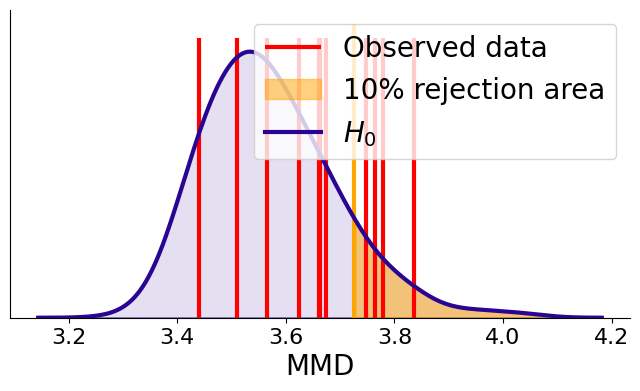

In [7]:
f=plot_mmd_hypothesis_test(null_distribution, observed, alpha_level=0.1)

In [17]:
for i, subject in enumerate(subjects):
    if p_value[i] < 0.1:
        print(subject)

subject-a
subject-b
subject-g
subject-k
